Librerías necesarias para el proyecto:

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import OneHotEncoder
import seaborn as sns
import matplotlib.pyplot as plt


import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D,MaxPooling2D,Dropout, Input, Concatenate, Lambda, GlobalAveragePooling2D
from tensorflow.keras.utils  import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.applications import  VGG16

from keras.callbacks import EarlyStopping

import sklearn
from   sklearn.model_selection import train_test_split


Vamos a establecer la semilla de la biblioteca numpy para que las pariciones y ejecuciones tengan el mismo resultado siempre que se ejecuten.

In [ ]:
np.random.seed(0)

Acceder al drive con el dataset:

In [ ]:
#Para acceder a nuestros ficheros de Google Drive
from google.colab import drive
drive.mount('/content/drive')
# La carpeta datos (que contiene X_train.npy, y_train.npy, X_test.npy y y_test.npy)
# debe estar en vuestro Drive, dentro de la carpeta 'Colab Notebooks'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Vamos a mapear cada clase para etiquetar las clases con valores numéricos además de la etiqeuea original que se trataba del nombre en formato string.

In [ ]:
map_labels = {
    'Apple Braeburn':0,
  'Apple Granny Smith':1,
  'Apricot':2,
  'Avocado':3,
  'Banana':4,
  'Blueberry':5,
  'Cactus fruit':6,
  'Cantaloupe':7,
  'Cherry':8,
  'Clementine':9,
  'Corn':10,
  'Cucumber Ripe':11,
  'Grape Blue':12,
  'Kiwi':13,
  'Lemon':14,
  'Limes':15,
  'Mango':16,
  'Onion White':17,
  'Orange':18,
  'Papaya':19,
  'Passion Fruit':20,
  'Peach':21,
  'Pear':22,
  'Pepper Green':23,
  'Pepper Red':24,
  'Pineapple':25,
  'Plum':26,
  'Pomegranate':27,
  'Potato Red':28,
  'Raspberry':29,
  'Strawberry':30,
  'Tomato':31,
  'Watermelon':32
}

Para poder cargar los datos en el colab hace falta que se añadan el conjunto de datos al drive personal en la carpeta `drive/MyDrive/Colab Notebooks/datos/` o cambiar el valor de `file_pat`h a la dirección donde se ha cargado el arhcivo con los datos `total_data.npz`.

In [ ]:
#Primera parte de los datos (parte de entrenamiento)
file_path = 'drive/MyDrive/Colab Notebooks/datos/total_data.npz'

loaded_data = np.load(file_path)
trainX = loaded_data['trainX'] # cargar el array con los valores de cada imagen de train
trainY_names = loaded_data['trainY'] # cargar el array con los valores de las etiquetas de train
testX = loaded_data['testX'] # cargar el array con los valores de cada imagen de test
testY_names = loaded_data['testY'] # cargar el array con los valores de las etiquetas de test


trainY = [map_labels[label] for label in trainY_names]
testY = [map_labels[label] for label in testY_names]


# Trasnformar en arrays de numpy para mayor eficiencia
trainX = np.array(trainX)
trainY = np.array(trainY)
testX = np.array(testX)
testY = np.array(testY)
#print(trainX[0])
#print(trainY[0])
# Mostrar dimension del conjunto de muestras total
print("Forma de vector trainX de muestras:", trainX.shape)
print("Forma de vector trainY de etiquetas:", trainY.shape)
print("Forma de vector testX de muestras:", testX.shape)
print("Forma de vector testY de etiquetas:", testY.shape)

Forma de vector trainX de muestras: (10112, 100, 100, 3)
Forma de vector trainY de etiquetas: (10112,)
Forma de vector testX de muestras: (6742, 100, 100, 3)
Forma de vector testY de etiquetas: (6742,)


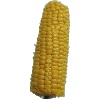

In [ ]:
encontrado = True
i = 1
while(encontrado):
  if(trainY[i] == 10):
    img = trainX[i]
    cv2_imshow(cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
    encontrado = False;
  else:
    i = i+1


Cada caso representa una imagen de una fruta y posee 100x100 píxeles a color, y por lo tanto los datos de cada caso consisten en una matriz con tres dimensiones de la forma (100,100,3) ya que cada píxel se compone de 3 valores enteros entre 0 y 255 que representan los tres colores Rojo Verde y Azul (RGB).

Inicialmente en la página web donde se obtienen los datos solo disponemos de los datos de train con sus etiquetas, los datos de test que hay en la página web no tienen etiquetas y por tanto no podemos usarlos para entrenar ni comprobar como test.

De forma local , al extraer los vectores de píxeles de las imágenes, hemos obtenido el conjunto total de muestras.

Después de obtener el conjunto total de datos hemos separado los datos en un conjunto de entrenamiento y otro de test. Realizamos esto lo primero para evitar observar los datos de test y realizar "Data Snooping" donde el conjunto de datos podría influenciar nuestra elección sobre el modelo a utilizar para resolver el problema de aprendizaje automático. Para separar las muestras en train y test, el rango de distribuciones comunes en la práctica es entre 60% train - 40% test y 90% train - 10% test. Al utilizar una distribución con mayor porcentaje para test obtendríamos una estimación mejor del error  $E_{out}$  a partir del error  $E{test}$  que con una distribución con menor porcentaje para test, ya que se utilizaría un número mayor de muestras para obtener la estimación. Sin embargo, al utilizar una distribución con mayor porcentaje para train obtendríamos un mejor ajuste del problema al entrenar el modelo de aprendizaje con más datos que con una distribución con menor porcentaje para train, teniendo una mejor generalización en el conjunto de entrenamiento de la función que tratamos de aproximar. En general cuantos más datos se utilicen en test mejor será la estimación del error $E_{out}$  y cuantos más datos se utilicen en el entrenamiento, el clasificador calculado se ajustará mejor al problema, ya que tiene más datos con los que aprender.  
En este problema además del objetivo de clasificar también se pretende generar muestras nuevas a partir de un número muy reducido de muestras y comparar el rendimiento del modelo de clasificación con ambos conjuntos de datos, el original y el creado. Es por eso que la estimación del error $E_{out}$ es importante en este problema y por lo tanto hemos elegido una distribución de 60% para entrenamiento y 40% de test, teniendo en cuenta que con esta distribución se tiene un número menor de datos para entrenar, pero se tiene un número mayor de datos para  estimar el error  Eout  y obtener una estimación del rendimiento del modelo con cada conjunto de datos más robusta.


# Preprocesado de los Datos

Vamos a modificar el vector de etiquetas ya que inicialmente cada etiqueta se ha representado como un número
$y_i \in \{0, 1, ..., 33\}$, a partir del mapeado de los nombres de las clases, y por tanto vamos a transformar estas etiquetas al espacio de salida $\mathcal Y$ donde cada etiqueta $y_i \in \mathcal Y$ identifica una clase de nuestro problema $C_{i}$ y es representado por un vector de 33 valores binarios donde todos los valores del vector toman el valor 0 excepto el valor en la posición $i$ que toma el valor 1 representando que la etiqueta es la clase $ i \in \{0,1,2,3...33\}$.

Para ello aplicamos One-Hot encoding a las etiquetas empleando la clase OneHotEncoder utilizando los siguiente parámetros para crear el objeto codificado:
*   categories: se especifica la lista categ que contiene las categorías de cada variable.
*   sparse_output=False: se establece en False para obtener una matriz densa en lugar de una matriz dispersa, para obtener una matriz con las columnas de cada nueva variable unificadas para añadirlas directamente al conjunto de datos.
*   drop=None: se establece en None para mantener todas las categorías en cada variable.
Después se utiliza el método fit_transform del objeto codificador para realizar la codificación One-Hot de las variables categóricas elegidas.


La técnica One-Hot encoding se utiliza para evitar que los algoritmos de aprendizaje automático aprendan relaciones entre el orden númerico que existe entre los números consecutivos o rangos que se utilizan para los atributos de los datos. Por eso se utiliza un vector de valores binarios para evitar que las clases puedan inferir relaciones erroneas y confundan al algoritmo a la hora de entrenar con los datos.

In [ ]:
# Etiquetas numéricas
categorias =  [np.arange(len(map_labels))]

# Reshape del vector de etiquetas a una matriz columna para aplicar el codificador al vector
trainY_reshaped = trainY.reshape(-1, 1)
testY_reshaped = testY.reshape(-1, 1)

#Funcion para codificar
encoder = OneHotEncoder(
     categories=categorias,  # Categorías de cada variable
     sparse_output=False,  # crea una matriz sparse cuando se pone TRUE
     drop  = None  #  No quitar categorías en cada variable
     )

trainY_encoded = encoder.fit_transform(trainY_reshaped) # Aplicar One Hot Encoding al conjunto entrenamiento
testY_encoded = encoder.fit_transform(testY_reshaped) # Aplicar One Hot Encoding al conjunto entrenamiento
print("Forma de vector Y del conjunto total de etiquetas:",trainY_encoded.shape)
print("Forma de vector Y del conjunto total de etiquetas:",testY_encoded.shape)

Forma de vector Y del conjunto total de etiquetas: (10112, 33)
Forma de vector Y del conjunto total de etiquetas: (6742, 33)


#### Desequilibrio de clases

Una parte importante a tener en cuenta sobre nuestro conjunto de datos es el desequilibrio de las clases presentes en nuestro dataset, esto es el nivel de representación de cada caracter de nuestro conjunto de training. Cuando hay un desbalanceo de una o más clases, ocurre una dominancia de una clase sobre otra, esto quiere decir, que nuestros modelos pueden aprender mucha información sobre un conjunto de clases que está muy representada en los datos y aprender muy poca información de otros más infrarepresentados. Nos interesa que todas las clases estén bien representadas para poder tener un modelo final de clasificación lo más potente y capáz posible en el dominio del problema y así poder tener una capacidad de clasificación sobre todas las clases posibles.

Hay que tener en cuenta que cuando particionamos el conjunto de datos en datos de training y test, puede haber cierto desbalanceo que depende de la partición concreta que hemos realizado, esto lo hemos abordado realizando una separación de los datos con previa aleatorización del conjunto entero, de manera que la distribución sea lo más independiente posible de la partición que hemos hecho.

Si visualizamos el conteo de todas las etiquetas $y$ para todos los ejemplos del conjunto de training podemos comprobar la distribución de las clases y tener una mejor percepción de este problema.

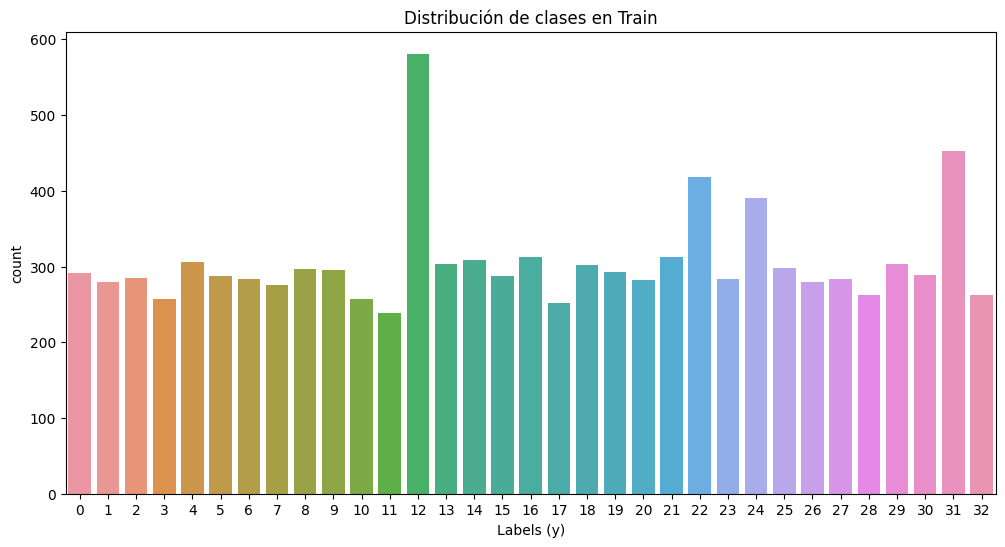

In [ ]:
plt.figure(figsize=(12, 6))
sns.countplot(x=trainY)

plt.title('Distribución de clases en Train')
plt.xlabel(f'Labels (y)')
plt.show()

Como podemos observar, existen algunas clases que tienen una cantidad mayor de muestras que el resto, pero en general la distribución es uniforme y por lo tanto no va a existir problemas durante el entrenamiento del modelo ya que al no existir clases sobrerepresentadas ni infrarepresentadas el modelo no va a favorecer ni desfavorecer a ninguna de las clases.

Como las variables consisten en píxeles a color con valores entre 0 y 255 para cada color, todas las variables están en la misma escala. Es importante destacar que estos análisis de los datos han de hacerse únicamente en el conjunto de entrenamiento ya que el conjunto de test es el que será utilizado para evaluar el modelo final y las elecciones tanto del modelo como de las transformaciones no deben influenciarse por la información de este conjunto, y así evitar cometer Data Snooping.

#Modelo de clasificación

Para los problemas de clasificación de imágenes, es común utilizar Redes Neuronales Convolucionales ya que han demostrado ser los mejores modelos para clasificar e identificar objetos y formas dentro de imágenes. Es por eso que hemos elegido un modelo de Red Neuronal Convolucional. El modelo consistirá en una serie de capas de modelo de Neuronas Convolucionales para extraer las carácterísticas más importantes de las imagenes y despúes una serie de capas de modelo de Red Neuronal Densa para aprender las características de las imágenes y clasificar según el tipo de fruta que aparezca en la imágen.


## Métricas de error

#### Métricas de error
A continuación vamos a definir cuales son las métricas de error a usar en este problema de clasificación así como decir para cada una que información nos aporta.

Las métricas que usaremos son por una parte, sacadas de la matriz de confusión, y otras, son específicas para problemas de clasificación multietiqueta. La matriz de confusión es una herramienta muy usada en Machine Learning para evaluar el rendimiento de un modelo de ML. Se suele usar mayoritariamente en problemas de clasificación y tiene una estructura tabular y que compara la frecuencia de clases predichas por el modelo y su valor real.

![](https://dataaspirant.com/3_confusion_matrix/)
_Figura tomada de https://dataaspirant.com/wp-content/uploads/2020/08/3_confusion_matrix.png_

A partir de la matriz de confusión se pueden calcular métricas para evaluar un modelo de clasificación. Entre ellas se encuentran las que usaremos que son:

- _Accuracy_ o exactitud: nos permite medir su tasa de clasificación correcta, es decir, la fracción de ejemplos que ha clasificado correctamente (independientemente de su clase). Se calcula como:
$$\frac{TP + TN}{TP + TN + FP + FN}$$
- _Specificity_ o especificidad: Mide la fracción de las muestras que han sido clasificadas como negativas y que realmente fueron negativas, es decir, nos da una métrica para medir que tan bien clasifica la clase negativa. Se calcula como:
$$\frac{TN}{TN + FP}$$
- F1-Score: Esta métrica combina dos métricas denominadas _Recall_ y _Precision_ en un valor único, y es especialmente útil cuando queremos encontrar un equilibrio entre los falsos positivos y falsos negativos. Se calcula como:
$$\frac{2\cdot (\text{Precision}\cdot \text{Recall})}{(\text{Precision}+ \text{Recall})}$$

Todas estas métricas se pueden adaptar facilmente a la clasificación multiclase calculando el valor de las métrica de las clases por separado y promediando todas las clases obteniendo el valor general de las métricas del modelo.

Como podemos observar, estamos eligiendo las métricas que nos pueden dar una mejor percepción global del rendimiento de un modelo. Si observamos por un lado la _Accuracy_ engloba la tasa de clasificación correcta de nuestro modelo, es decir, cuanto acierta nuestro modelo en proporción, esta métrica se considera de las más importantes porque es la que más engloba el rendimiento de un clasificador sin importar la clase que esta prediciendo. Sin embargo,distintos modelos mejores y peores pueden obtener valores parecidos en la métrica de accuracy debido a su estructura interna ya que solo mide los aciertos promedios y no tiene en cuenta que tipo de fallos comete ni en que partes de la clasificación.

Por lo tanto para tener más valoraciones de los modelos y poder evaluar sus rendimientos en este caso utilizamos por un lado F1-Score, ya que se considera un métrica muy robusta que balancea el peso de la clase menos representada realizando la media armónica de la métrica _Recall_ y de la _Precision_. Sin embargo, el _Recall_ y la _Precision_ solo tienen en cuenta la clase positiva y ahí es donde entra la última métrica, la _Specificity_ que mide como de bien clasifica la clase negativa, completando el cálculo del rendimiento de un modelo.

Con estas métricas seremos capaces de elegir de forma sensata y con bastante criterio aquel modelo que mejor clasifica una muestra de datos.


Como valoración global vamos a definir nuestro criterio de selección. Para ello vamos a crear una métrica que comprende estas tres métricas que cabamos de explicar y es una suma ponderada de estas tres:
$$\alpha_1 \cdot Acc + \alpha_2 \cdot Spec + \alpha_3 \cdot \text{F1}$$

De esta manera, podemos definir los coeficientes $\alpha_i$ según que métricas resultan más importantes o con más peso a la hora de elegir un modelo u otro. Por tanto definiremos estos coeficientes tomándo en cuenta lo siguiente:
- Sabemos que las clases de nuestro conjunto de entrenamiento no tienen algún tipo de desbalanceo importante, por lo que realmente la medición de la _accuracy_ resulta una buena métrica en este caso para comparar los modelos, ya que al estar las clases aproximadamente equitativamente bien representadas entonces un modelo con un _accuracy_ muy alto significa un modelo que está clasificando la mayoría de los ejemplos correctamente y no porque sea una clase mayoritaria. Por tanto, a esta métrica le daremos un peso importante.
- Por otro lado, el F1-Score es una métrica que combina el _Precision_ y el _Recall_ en una sola métrica, por tanto, resulta útil cuando queremos evitar la sobreestimación o subestimación de los errores en la clasificación. En nuestro caso, los errores en clasificación de frutas no son tan relevantes como lo son los aciertos, sobre todo en clasificación multietiqueta donde la clasificación de no pertenencia de una clase es casi una forma de comportamiento por defecto, ya que la gran mayoría de clases responderan negativamente a la pertenencia del ejemplo a ellas y solo una responderá positivamente; por lo que nos interesa elegir un modelo que clasifica bien un ejemplo. Por tanto, al F1-Score tendrá un peso más bien bajo.
- Finalmente, la especificidad mide que tan bien clasifica los casos negativos, en sí el caso es muy similar al de F1-Score, donde nos interesa más premiar los modelos que acierten mejor, por lo que este tendrá un peso muy similar al F1-Score.

Por tanto, podemos asignar unos valores aproximados según las consideraciones de cada métrica con el problema al que nos enfrentamos. Por lo que proporcionamos la siguiente asignación:
$$\text{Score}(h) = 0.7 \cdot Acc(h) + 0.15 \cdot Spec(h) + 0.15\cdot F1(h)$$



En la biblioteca de TensorFlow ya existen implementaciones de las métricas de Accuracy y de F1-Score, pero no de Sensitivity. Por lo tanto vamos a crear una métrica personalizada para Sensitivity y también para la métrica que acabamos de definir. Por motivos de la implementación de la biblioteca hace falta definir una clase para cada métrica con unas funciones auxiliares heredadas, pero la implementación de la métrica está en la función `result()` dentro de las clases deifinidas.

In [ ]:
class CustomSensitivity(tf.keras.metrics.Metric):
    def __init__(self, name='sensitivity', **kwargs):
        super(CustomSensitivity, self).__init__(name=name, **kwargs)
        self.true_positives = self.add_weight('tp', initializer='zeros')
        self.false_negatives = self.add_weight('fn', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.cast(y_true, dtype=tf.bool)
        y_pred = tf.cast(y_pred > 0.5, dtype=tf.bool)  # Assuming binary classification with a threshold of 0.5

        true_positives = tf.math.logical_and(y_true, y_pred)
        false_negatives = tf.math.logical_and(y_true, tf.math.logical_not(y_pred))

        self.true_positives.assign_add(tf.reduce_sum(tf.cast(true_positives, tf.float32)))
        self.false_negatives.assign_add(tf.reduce_sum(tf.cast(false_negatives, tf.float32)))

    def result(self):
        return self.true_positives / (self.true_positives + self.false_negatives)


In [ ]:
class CustomScoreMetric(tf.keras.metrics.Metric):
    def __init__(self, **kwargs):
        super(CustomScoreMetric, self).__init__(name='custom_score', **kwargs)
        self.cat_accuracy = tf.keras.metrics.CategoricalAccuracy()
        self.f1_score = tf.keras.metrics.F1Score()
        self.custom_sensitivity = CustomSensitivity()

    def update_state(self, y_true, y_pred, sample_weight=None):
        self.cat_accuracy.update_state(y_true, y_pred)
        self.f1_score.update_state(y_true, y_pred)
        self.custom_sensitivity.update_state(y_true, y_pred)

    def result(self):
        acc = self.cat_accuracy.result()
        f1 = self.f1_score.result()
        sens = self.custom_sensitivity.result()

        return 0.7 * acc + 0.15 * sens + 0.15 * f1

    def reset_state(self):
        self.cat_accuracy.reset_state()
        self.f1_score.reset_state()
        self.custom_sensitivity.reset_state()


##Red Neuronal Convolucional (CNN)

Para crear el modelo de Red Neuronal Convolucional se utiliza la  la biblioteca de Python Keras, que tiene una interfaz de alto nivel para redes neuronales que trabaja sobre varios motores de cálculo subyacentes, y en este caso utilizaremos TensorFlow. Keras funciona sobre varios motores de cálculo, pero TensorFlow es uno de los backends más utilizados por Keras. TensorFlow provee herramientas para construir y entrenar redes neuronales, y es utilizado comúnmente en conjunción con Keras para el desarrollo de modelos de aprendizaje profundo.
En detalle se explican las funciones y parametros que se utilizan para crear el modelo:
- `Sequential()`: Se crea un modelo secuencial de Keras. Este tipo de modelo permite agregar capas secuencialmente, una tras otra para crear el modelo personalizado.

- `Conv2D`: Capa convolucional que aplica un conjunto de filtros convolucionales a la entrada. La función de activación ReLU se aplica después de la convolución. Los parámetros de entrada de la función representan lo siguiente:

  - Número de filtros/neuronas convolucionales (32, 64, 128 dependiendo de cada capa).
  - Tamaño de la ventana de convolución en Conv2D: Determina las dimensiones del filtro que se desplaza sobre la imagen de entrada. Un valor como (3, 3) especifica un filtro de 3x3 píxeles que busca patrones locales, influyendo en la extracción de características, la cantidad de parámetros del modelo y la información espacial capturada en la imagen.
  - Función de activación ReLU.

- `MaxPooling2D`: Capa de submuestreo que reduce el tamaño espacial de la salida y reduce la cantidad de parámetros a aprender. Los parámetros de entrada de la función representan lo siguiente:
  - Tamaño de la ventana de pooling en MaxPooling2D: Define las dimensiones de la ventana que reduce el tamaño espacial de la salida de la capa previa. Por ejemplo, (2, 2) indica una ventana de 2x2 píxeles. Esto controla la reducción de la resolución espacial y la retención de características relevantes al realizar el submuestreo.

- `Flatten()`: Capa que convierte los mapas de características bidimensionales en un vector unidimensional para alimentar las capas densas.

- `Dense`: Capa densa o completamente conectada. Se definen las neuronas y la función de activación para las capas densas. Los parámetros de entrada de la función representan lo siguiente:
  - Número de neuronas (64 en una capa).
  - Función de activación ReLU en capas densas.
  - Capa de salida con un número de neuronas igual al número de clases en el problema.
  - Utiliza la función de activación Softmax para obtener probabilidades de cada clase.

- `modeloCNN.summary()`: Muestra un resumen detallado de la arquitectura del modelo, incluyendo el tipo de capa, el tamaño de salida y la cantidad de parámetros entrenables en cada capa.

Este modelo es una red neuronal convolucional para clasificación de imágenes, compuesta por capas convolucionales, capas de submuestreo, capas completamente conectadas y una capa de salida para clasificación multi-clase.


Como función de pérdida para el modelo utilizamos la función de entropía cruzada ya que experimentalmente se ha visto que esta función obtiene buenos resultados en modelos de redes neuronales.  

**Entropía Cruzada (Cross Entropy)** es una función de pérdida comúnmente utilizada en problemas de clasificación en modelos de aprendizaje automático, incluyendo redes neuronales, para evaluar la discrepancia entre la distribución de probabilidad estimada por el modelo y la distribución real de los datos.

Aspectos clave de la Entropía Cruzada en el modelo:

- **Métrica de discrepancia:** Evalúa la diferencia entre la distribución de probabilidad predicha por el modelo y la distribución real de las etiquetas. En clasificación, se centra en la predicción de la clase correcta.

- **Utilizada en problemas de clasificación:** Es particularmente efectiva en problemas de clasificación multiclase, donde la red debe asignar una clase a una entrada entre múltiples clases posibles.

- **Función de pérdida para entrenamiento:** La Entropía Cruzada se utiliza como una función de pérdida durante el entrenamiento del modelo, donde se busca minimizar la discrepancia entre las predicciones y las etiquetas reales.

- **Múltiplas variantes:** Hay diferentes tipos de Entropía Cruzada, como Categórica (Categorical), Binaria (Binary), o Sparce, cada una adecuada para diferentes tipos de problemas de clasificación. En nuestro caso utilizamos la variante categórica ya que tenemos 33 clases de frutas distintas.

La función de Entropía Cruzada (Cross Entropy) se expresa matemáticamente como:

$$ H(y, \hat{y}) = - \frac{1}{N} \sum_{i=1}^{N} \left( y_i \cdot \log(\hat{y}_i) + (1 - y_i) \cdot \log(1 - \hat{y}_i) \right) $$

Donde:
- $y$ representa las etiquetas reales.
- $\hat{y}$ representa las predicciones del modelo.
- $N$ es el número de ejemplos.


Al utilizar la Entropía Cruzada como función de pérdida en un modelo de CNN, se busca minimizar la discrepancia entre las predicciones del modelo y las etiquetas reales, optimizando así la capacidad del modelo para realizar predicciones precisas en problemas de clasificación.


La **función de activación ReLU (Rectified Linear Unit)** es una de las funciones más utilizadas en redes neuronales. Su definición matemática es  
>$ f(x) = \max(0, x) $  


lo que implica que si el valor de entrada $ x $ es mayor que cero, la función retorna el mismo valor $ x $; en caso contrario, retorna cero.

En el modelo de red neuronal convolucional (CNN) se utiliza la función ReLU después de las capas convolucionales y en la capa completamente conectada. Se implementa mediante el parámetro `activation='relu'` en las capas `Conv2D` y `Dense`.

Las razones clave para el uso de ReLU son las siguientes:

- **No tiene valor máximo:** ReLU no tiene un límite superior y no satura en la región positiva, lo que ayuda a evitar el problema de saturación presente en funciones como la sigmoide o la tangente hiperbólica, donde el gradiente en valores cercanos al máximo y mínimo tiende a desvanecerse y a decrecer significativamente, provocando que el entrenamiento se relentice. De este modo ReLu permite un entrenamiento más rápido. Además esto favorece la convergencia durante el entrenamiento.

- **Eficiencia computacional:** También es más eficiente en términos de cómputo que algunas funciones de activación más complejas.

La utilización de ReLU en el modelo permite la introducción de no linealidad en las capas, lo que posibilita que el modelo capture y aprenda patrones complejos presentes en los datos de entrada. En resumen, su aplicación en las operaciones de convolución y las capas densas mejora la capacidad del modelo para aprender y extraer características relevantes favoreciendo la clasificación de imágenes.


La función de activación Softmax se utiliza comúnmente en la capa de salida de una red neuronal, especialmente en problemas de clasificación multiclase.  
Su definición matemática es  
>$ \sigma(z)_j = \frac{e^{z_j}}{\sum_{k=1}^{K} e^{z_k}} $  

donde $ z $ es un vector de entradas a la función, $ K $ es el número total de clases y $ j $ es la clase específica. En el modelo se utiliza esta función de activación en la capa de salida para generar como resultado las probabilidades de pertenencer a cada clase en el formato de salida indicado para este problema.

Principales aspectos de la función Softmax:

- **Probabilidades normalizadas:** Transforma un vector de números reales en un vector de probabilidades normalizadas que suman 1. Estas probabilidades representan la confianza del modelo en cada clase para una entrada dada.

- **Útil en clasificación multiclase:** Es útil en problemas donde se requiere asignar una sola etiqueta a cada ejemplo de entrada entre varias clases posibles.

- **Salida para clasificación:** La clase con la probabilidad más alta después de aplicar Softmax se considera la predicción del modelo para la entrada dada.

La función Softmax es crucial en la etapa de clasificación, ya que proporciona una salida interpretable y adecuada para la toma de decisiones sobre la pertenencia de una entrada a diferentes categorías.


**Early Stopping (Detención Temprana)** es una técnica de regularización utilizada durante el entrenamiento de modelos de aprendizaje automático, en particular, redes neuronales. Su objetivo principal es evitar el sobreajuste del modelo y mejorar la capacidad de generalización.

Principales aspectos de Early Stopping:

- **Control del rendimiento:** Durante el entrenamiento, Early Stopping supervisa el rendimiento del modelo en un conjunto de validación. Este rendimiento se mide utilizando una métrica, como la fucnión de pérdida u otras métricas como accuracy.

- **Detención cuando empeora:** Early Stopping detiene el entrenamiento si el rendimiento en el conjunto de validación empeora en comparación con iteraciones anteriores. Este empeoramiento se conoce como "sobreajuste" y se puede detectar por un aumento en la pérdida en lugar de una disminución.

- **Mejora de la generalización:** Al detener el entrenamiento en el momento adecuado, Early Stopping ayuda a que el modelo mantenga su capacidad de generalización y evita que memorice el conjunto de entrenamiento.

- **Ajuste de hiperparámetros:** Los hiperparámetros importantes en Early Stopping incluyen la métrica de evaluación, la paciencia (número de épocas sin mejora antes de detener) y la restauración de los pesos del modelo en la última iteración de mejora.

Early Stopping es una herramienta esencial para mejorar la robustez y el rendimiento de los modelos de aprendizaje automático al evitar el sobreajuste y promover una mejor generalización.


**Adam** es un algoritmo de optimización comúnmente utilizado en el entrenamiento de modelos de aprendizaje automático, incluyendo redes neuronales, que combina la técnica de descenso de gradiente estocástico con adaptabilidad en la tasa de aprendizaje.

Aspectos clave de Adam como optimizador en `model.compile`:

- **Adaptabilidad de la tasa de aprendizaje:** Adam ajusta automáticamente la tasa de aprendizaje del modelo a lo largo del entrenamiento para cada parámetro, basándose en estimaciones de primer y segundo momento de los gradientes.

- **Eficiencia y rapidez:** Integra las ventajas del descenso de gradiente estocástico con tasas de aprendizaje adaptativas, lo que lo hace efectivo en una amplia gama de problemas de optimización y lo hace converger más rápidamente.

- **Tasa de aprendizaje adaptativa por parámetro:** Adam mantiene tasas de aprendizaje independientes por parámetro y las adapta según la magnitud del gradiente, resultando en un entrenamiento más suave y eficiente.

- **Valores predeterminadas eficaces:** Adam posee valores predeterminados que suelen funcionar bien en una variedad de tareas, lo que facilita su uso y configuración.

Al utilizar Adam como optimizador en `model.compile`, se emplea un algoritmo robusto y eficiente que adaptativamente ajusta las tasas de aprendizaje para acelerar la convergencia y mejorar el rendimiento del modelo durante el entrenamiento.


**MaxPooling2D** es una capa comúnmente empleada en las redes neuronales convolucionales (CNN) para el procesamiento de imágenes y otros datos con estructura similar. Su principal objetivo es realizar el submuestreo (downsampling) de las características extraídas de la capa anterior, reduciendo la resolución espacial.

Aspectos clave de MaxPooling2D en el modelo:

- **Reducción de la dimensionalidad:** MaxPooling2D reduce la resolución espacial de la salida de la capa anterior al seleccionar el valor máximo de una ventana deslizante (kernel) en la entrada. Esto disminuye la cantidad de parámetros y cálculos necesarios en capas subsiguientes.

- **Conservación de características relevantes:** MaxPooling2D conserva las características más prominentes en cada ventana, permitiendo que el modelo se enfoque en las características más importantes mientras reduce el ruido o detalles menos significativos.

- **Parámetros configurables:** La dimensión de la ventana de MaxPooling2D se configura, por ejemplo, `(2, 2)` indica una ventana de 2x2 píxeles, y el stride (desplazamiento) controla la cantidad de traslape entre ventanas.

- **Utilización en arquitecturas CNN:** MaxPooling2D es un componente fundamental en las CNN para crear representaciones jerárquicas de características en imágenes y otras estructuras de datos.

Al utilizar MaxPooling2D en un modelo de CNN, se logra la reducción de la resolución espacial en las características, lo que simplifica el modelo y mejora la capacidad de generalización.


## Elección de Hiperparámetros

La elección de los hiperparámetros del modelo se realiza en otro cuaderno de colab para no tener que ejecutar todo el proceso, ya que conlleva entrenar una cantidad significativa de modelos con distintos hiperparámetros y comparar su rendimiento para elegir los mejores hiperparámetros mediante las técnicas que en ese cuaderno se explican. Este proceso lleva bastante tiempo de computación y por tanto se pueden observar los resultados obtenidos en las tablas de los hiperparámetros sin ejecutarlo para comprobar el rendimiento del modelo con los distintos hiperparámetros. Finalmente, como resultado del proceso de elección de hiperparámetros se han obtenido los valores ideales obteniendo el modelo con el que vamos a comparar los resultados.

## Modelo Final

Finalmente establecemos el modelo final con los hiperparámetros elegidos como se ha explicado antes:

In [ ]:
input_shape = trainX[0].shape
num_classes = len(map_labels)

Definir hiperparámetros:

In [ ]:
# Valores de los hiperparámetros
conv_neurons = [32,64,128]
conv_window = [[3,3],[3,3],[3,3]]
num_maxPooling = [[2,2],[2,2],[2,2]]
dense_neurons = 64
batch_size = 96
epochs = 4

Crear modelo

In [ ]:
modeloCNN = Sequential()

# Capa convolucional 1
modeloCNN.add(Conv2D(conv_neurons[0], conv_window[0], activation='relu', input_shape=input_shape))
modeloCNN.add(MaxPooling2D(num_maxPooling[0]))

# Capa convolucional 2
modeloCNN.add(Conv2D(conv_neurons[1], conv_window[1], activation='relu'))
modeloCNN.add(MaxPooling2D(num_maxPooling[1]))

# Capa convolucional 3
modeloCNN.add(Conv2D(conv_neurons[2], conv_window[2], activation='relu'))
modeloCNN.add(MaxPooling2D(num_maxPooling[2]))

# Capa de aplanamiento
modeloCNN.add(Flatten())

# Capa completamente conectada
modeloCNN.add(Dense(dense_neurons, activation='relu'))

# Capa de salida
modeloCNN.add(Dense(num_classes, activation='softmax'))

modeloCNN.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 98, 98, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 49, 49, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 47, 47, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 23, 23, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 21, 21, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 10, 10, 128)       0

Compilamos el modelo

In [ ]:
modeloCNN.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=[
        tf.keras.metrics.CategoricalAccuracy(),
        tf.keras.metrics.F1Score(),
        CustomSensitivity(),
        CustomScoreMetric()
    ],
)

Aplicamos Early Stopping:

In [ ]:
# Define Early Stopping
early_stopping = EarlyStopping(monitor='loss', patience=3, restore_best_weights=True)

Crear conjunto de validación:

In [ ]:
# Obtener conjuntos de validación y train
trainX_CNN, valX_CNN, trainY_CNN, valY_CNN = train_test_split(trainX, trainY_encoded, test_size=0.40)

Entrenamos el modelo

In [ ]:

# Entrenar el modelo
history = modeloCNN.fit(
  trainX_CNN, trainY_CNN,
  epochs=epochs,
  batch_size=batch_size,
  verbose = 1, # Cantidad de información a mostrar mientras se entrena
  callbacks=[early_stopping]
)

Epoch 1/4


KeyboardInterrupt: ignored

Evaluamos el modelo con el conjunto de validación:

In [ ]:
# Evaluar el modelo
results = modeloCNN.evaluate(valX_CNN,valY_CNN)

funcionPerdidaTabla = []
accuracyTabla = []
f1Tabla = []
sensitivityTabla = []
customScoreTabla = []
accuracyTabla.append(results[1])
f1Tabla.append(results[2].mean())
funcionPerdidaTabla.append(results[0])
sensitivityTabla.append(results[3])
customScoreTabla.append(results[4].mean())


#Crear DataFrame y mostrarlo
tableFrame = pd.DataFrame({'Error de validación (función de pérdida)':funcionPerdidaTabla,
                           'Accuracy':accuracyTabla,'F1-Score':f1Tabla,'Sensitivity':sensitivityTabla, 'Métrica personalizada':customScoreTabla})
display(tableFrame)

A partir de los resultados podemos ver que en el conjunto de validación el modelo obtiene muy buenos resultados, casi perfectos. Se podría pensar que esto es debido a un sobreajuste del modelo pero ya que se ha utilizado un conjunto de validación que el modelo no utiliza para entrenar y solo lo utiliza para evaluar el modelo con las métricas, el modelo no está influenciado por este conjunto y las imagenes son una muestra del conjunto de posibles muestras en general y por tanto el resultado del rendimiento es un buen resultado que muestra que el modelo se ha ajustado bien a problema.

#Comparación de Conjuntos de Datos

Vamos a cargar todos los conjuntos de datos generados y a compararlos entrenando el modelo con cada uno y evaluando su rendimeinto con el conjunto de test, que fue apartado del conjunto global al principio para evaluar el modelo sobre los distintos conjuntos de entrenamiento y no se ha utilizado para nada más para evitar cometer Data Snooping.

In [ ]:
file_path2 = 'drive/MyDrive/Colab Notebooks/datos/data_dos_transformaciones.npz'
file_path3 = 'drive/MyDrive/Colab Notebooks/datos/data_tres_transformaciones.npz'
file_path4 = 'drive/MyDrive/Colab Notebooks/datos/data_cuatro_transformaciones.npz'

loaded_data2 = np.load(file_path2)
trainX_2 = loaded_data2['data'] # cargar el array con los valores de cada imagen de train
trainY_2 = loaded_data2['labels'] # cargar el array con los valores de las etiquetas de train

loaded_data3 = np.load(file_path3)
trainX_3 = loaded_data3['data'] # cargar el array con los valores de cada imagen de train
trainY_3 = loaded_data3['labels'] # cargar el array con los valores de las etiquetas de train

loaded_data4 = np.load(file_path4)
trainX_4 = loaded_data4['data'] # cargar el array con los valores de cada imagen de train
trainY_4 = loaded_data4['labels'] # cargar el array con los valores de las etiquetas de train



# Transformar en arrays de numpy para mayor eficiencia
trainX_2 = np.array(trainX_2)
trainY_2 = np.array(trainY_2)

trainX_3 = np.array(trainX_3)
trainY_3 = np.array(trainY_3)

trainX_4 = np.array(trainX_4)
trainY_4 = np.array(trainY_4)


# Mostrar dimension del conjunto de muestras total
print("Forma de vector trainX_2 de muestras:", trainX_2.shape)
print("Forma de vector trainY_2 de etiquetas:", trainY_2.shape)

print("Forma de vector trainX_3 de muestras:", trainX_3.shape)
print("Forma de vector trainY_3 de etiquetas:", trainY_3.shape)

print("Forma de vector trainX_4 de muestras:", trainX_4.shape)
print("Forma de vector trainY_4 de etiquetas:", trainY_4.shape)

Forma de vector trainX_2 de muestras: (13200, 100, 100, 3)
Forma de vector trainY_2 de etiquetas: (13200,)
Forma de vector trainX_3 de muestras: (33000, 100, 100, 3)
Forma de vector trainY_3 de etiquetas: (33000,)
Forma de vector trainX_4 de muestras: (66000, 100, 100, 3)
Forma de vector trainY_4 de etiquetas: (66000,)


Mismo preprocesado de datos

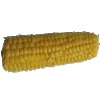

10


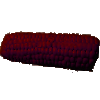

10


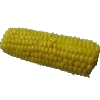

10


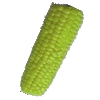

10


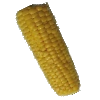

10


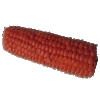

10


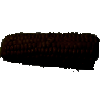

10


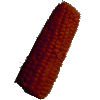

10


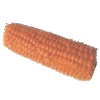

10


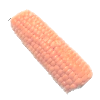

10


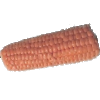

10


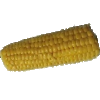

10


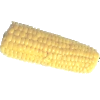

10


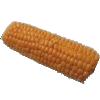

10


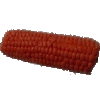

10


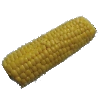

10


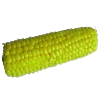

10


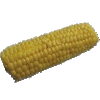

10


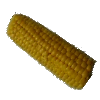

10


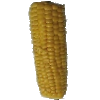

10


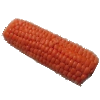

10


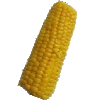

10


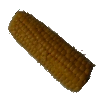

10


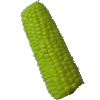

10


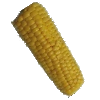

10


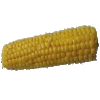

10


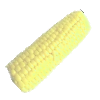

10


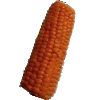

10


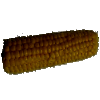

10


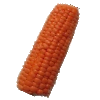

10


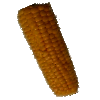

10


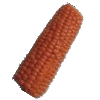

10


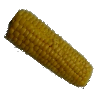

10


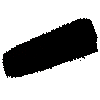

10


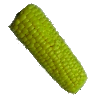

10


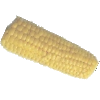

10


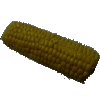

10


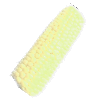

10


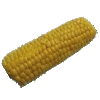

10


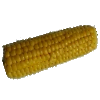

10


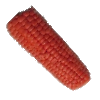

10


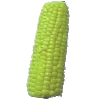

10


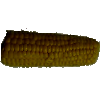

10


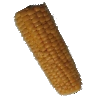

10


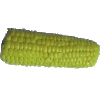

10


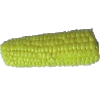

10


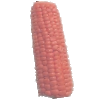

10


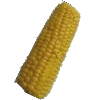

10


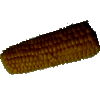

10


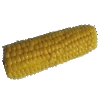

10


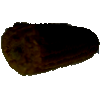

10


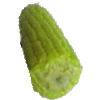

10


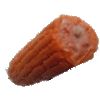

10


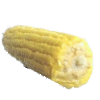

10


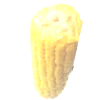

10


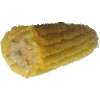

10


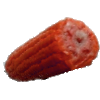

10


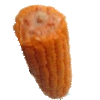

10


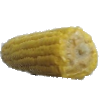

10


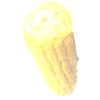

10


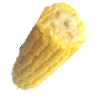

10


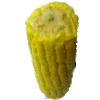

10


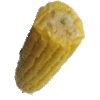

10


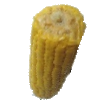

10


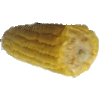

10


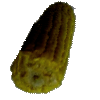

10


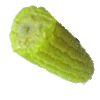

10


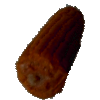

10


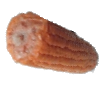

10


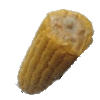

10


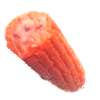

10


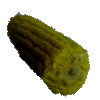

10


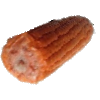

10


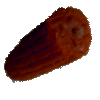

10


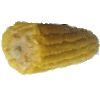

10


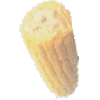

10


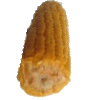

10


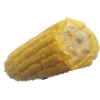

10


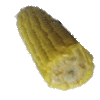

10


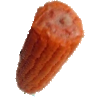

10


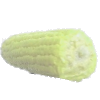

10


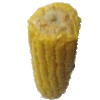

10


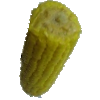

10


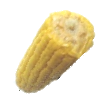

10


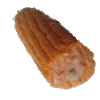

10


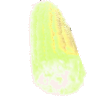

10


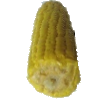

10


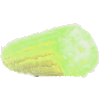

10


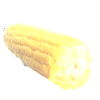

10


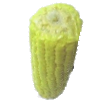

10


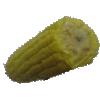

10


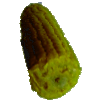

10


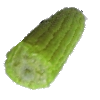

10


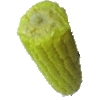

10


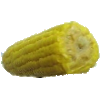

10


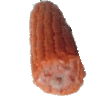

10


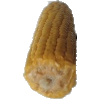

10


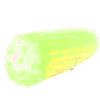

10


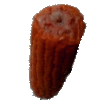

10


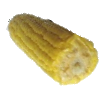

10


In [ ]:
import cv2
from google.colab.patches import cv2_imshow
for i in range(10000,10100):
  img = trainX_3[i]
  cv2_imshow(cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
  print(trainY_3[i])

In [ ]:

# Etiquetas numéricas
categorias =  [np.arange(len(map_labels))]

# Reshape del vector de etiquetas a una matriz columna para aplicar el codificador al vector
trainY_2reshaped = trainY_2.reshape(-1, 1)
trainY_3reshaped = trainY_3.reshape(-1, 1)
trainY_4reshaped = trainY_4.reshape(-1, 1)

#Funcion para codificar
encoder = OneHotEncoder(
     categories=categorias,  # Categorías de cada variable
     sparse_output=False,  # crea una matriz sparse cuando se pone TRUE
     drop  = None  #  No quitar categorías en cada variable
     )

trainY_2encoded = encoder.fit_transform(trainY_2reshaped) # Aplicar One Hot Encoding al conjunto entrenamiento
trainY_3encoded = encoder.fit_transform(trainY_3reshaped) # Aplicar One Hot Encoding al conjunto entrenamiento
trainY_4encoded = encoder.fit_transform(trainY_4reshaped) # Aplicar One Hot Encoding al conjunto entrenamiento
print("Forma de vector Y del conjunto total de etiquetas:",trainY_2encoded.shape)
print("Forma de vector Y del conjunto total de etiquetas:",trainY_3encoded.shape)
print("Forma de vector Y del conjunto total de etiquetas:",trainY_4encoded.shape)

##Entrenamiento con los conjuntos

vamos a entrenar el modelo con cada conjunto de datos y evaluar el rendimiento del modelo con el conjunto de test. Los resultados los mostramos en una tabla para poder comparar entre ellos.

In [ ]:
funcionPerdidaTabla = []
accuracyTabla = []
f1Tabla = []
sensitivityTabla = []
customScoreTabla = []
modeloTabla = []

In [ ]:
epochs = 4

>Conjunto Original

Creamos y compilamos el modelo:

In [ ]:
modeloCNN1 = Sequential()
modeloCNN1.add(Conv2D(conv_neurons[0], conv_window[0], activation='relu', input_shape=input_shape))
modeloCNN1.add(MaxPooling2D(num_maxPooling[0]))
modeloCNN1.add(Conv2D(conv_neurons[1], conv_window[1], activation='relu'))
modeloCNN1.add(MaxPooling2D(num_maxPooling[1]))
modeloCNN1.add(Conv2D(conv_neurons[2], conv_window[2], activation='relu'))
modeloCNN1.add(MaxPooling2D(num_maxPooling[2]))
modeloCNN1.add(Flatten())
modeloCNN1.add(Dense(dense_neurons, activation='relu'))
modeloCNN1.add(Dense(num_classes, activation='softmax'))
modeloCNN1.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=[
        tf.keras.metrics.CategoricalAccuracy(),
        tf.keras.metrics.F1Score(),
        CustomSensitivity(),
        CustomScoreMetric()
    ],
)

Entrenamos y evaluamos el modelo:

In [ ]:
# Entrenar el modelo
history = modeloCNN1.fit(
  trainX, trainY_encoded,
  epochs=epochs,
  batch_size=batch_size,
  verbose = 1, # Cantidad de información a mostrar mientras se entrena
  callbacks=[early_stopping]
)

# Evaluar el modelo
results = modeloCNN1.evaluate(testX,testY_encoded)

modeloTabla.append('Conjunto Generado 1')
accuracyTabla.append(results[1])
f1Tabla.append(results[2].mean())
funcionPerdidaTabla.append(results[0])
sensitivityTabla.append(results[3])
customScoreTabla.append(results[4].mean())

>Conjunto Generado 2

Creamos y compilamos el modelo:

In [ ]:
modeloCNN2 = Sequential()
modeloCNN2.add(Conv2D(conv_neurons[0], conv_window[0], activation='relu', input_shape=input_shape))
modeloCNN2.add(MaxPooling2D(num_maxPooling[0]))
modeloCNN2.add(Conv2D(conv_neurons[1], conv_window[1], activation='relu'))
modeloCNN2.add(MaxPooling2D(num_maxPooling[1]))
modeloCNN2.add(Conv2D(conv_neurons[2], conv_window[2], activation='relu'))
modeloCNN2.add(MaxPooling2D(num_maxPooling[2]))
modeloCNN2.add(Flatten())
modeloCNN2.add(Dense(dense_neurons, activation='relu'))
modeloCNN2.add(Dense(num_classes, activation='softmax'))
modeloCNN2.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=[
        tf.keras.metrics.CategoricalAccuracy(),
        tf.keras.metrics.F1Score(),
        CustomSensitivity(),
        CustomScoreMetric()
    ],
)

Entrenamos y evaluamos el modelo:

In [ ]:
# Entrenar el modelo
history = modeloCNN2.fit(
  trainX_2, trainY_2encoded,
  epochs=epochs,
  batch_size=batch_size,
  verbose = 1, # Cantidad de información a mostrar mientras se entrena
  callbacks=[early_stopping]
)

# Evaluar el modelo
results = modeloCNN2.evaluate(testX,testY_encoded)

modeloTabla.append('Conjunto Generado 2')
accuracyTabla.append(results[1])
f1Tabla.append(results[2].mean())
funcionPerdidaTabla.append(results[0])
sensitivityTabla.append(results[3])
customScoreTabla.append(results[4].mean())

>Conjunto Generado 3

Creamos y compilamos el modelo:

In [ ]:
modeloCNN3 = Sequential()
modeloCNN3.add(Conv2D(conv_neurons[0], conv_window[0], activation='relu', input_shape=input_shape))
modeloCNN3.add(MaxPooling2D(num_maxPooling[0]))
modeloCNN3.add(Conv2D(conv_neurons[1], conv_window[1], activation='relu'))
modeloCNN3.add(MaxPooling2D(num_maxPooling[1]))
modeloCNN3.add(Conv2D(conv_neurons[2], conv_window[2], activation='relu'))
modeloCNN3.add(MaxPooling2D(num_maxPooling[2]))
modeloCNN3.add(Flatten())
modeloCNN3.add(Dense(dense_neurons, activation='relu'))
modeloCNN3.add(Dense(num_classes, activation='softmax'))
modeloCNN3.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=[
        tf.keras.metrics.CategoricalAccuracy(),
        tf.keras.metrics.F1Score(),
        CustomSensitivity(),
        CustomScoreMetric()
    ],
)

Entrenamos y evaluamos el modelo:

In [ ]:
# Entrenar el modelo
history = modeloCNN3.fit(
  trainX_3, trainY_3encoded,
  epochs=epochs,
  batch_size=batch_size,
  verbose = 1, # Cantidad de información a mostrar mientras se entrena
  callbacks=[early_stopping]
)

# Evaluar el modelo
results = modeloCNN3.evaluate(testX,testY_encoded)

modeloTabla.append('Conjunto Generado 3')
accuracyTabla.append(results[1])
f1Tabla.append(results[2].mean())
funcionPerdidaTabla.append(results[0])
sensitivityTabla.append(results[3])
customScoreTabla.append(results[4].mean())

>Conjunto Generado 4

Creamos y compilamos el modelo:

In [ ]:
modeloCNN4 = Sequential()
modeloCNN4.add(Conv2D(conv_neurons[0], conv_window[0], activation='relu', input_shape=input_shape))
modeloCNN4.add(MaxPooling2D(num_maxPooling[0]))
modeloCNN4.add(Conv2D(conv_neurons[1], conv_window[1], activation='relu'))
modeloCNN4.add(MaxPooling2D(num_maxPooling[1]))
modeloCNN4.add(Conv2D(conv_neurons[2], conv_window[2], activation='relu'))
modeloCNN4.add(MaxPooling2D(num_maxPooling[2]))
modeloCNN4.add(Flatten())
modeloCNN4.add(Dense(dense_neurons, activation='relu'))
modeloCNN4.add(Dense(num_classes, activation='softmax'))
modeloCNN4.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=[
        tf.keras.metrics.CategoricalAccuracy(),
        tf.keras.metrics.F1Score(),
        CustomSensitivity(),
        CustomScoreMetric()
    ],
)

Entrenamos y evaluamos el modelo:

In [ ]:
# Entrenar el modelo
history = modeloCNN4.fit(
  trainX_4, trainY_4encoded,
  epochs=epochs,
  batch_size=batch_size,
  verbose = 1, # Cantidad de información a mostrar mientras se entrena
  callbacks=[early_stopping]
)

# Evaluar el modelo
results = modeloCNN4.evaluate(testX,testY_encoded)

modeloTabla.append('Conjunto Generado 4')
accuracyTabla.append(results[1])
f1Tabla.append(results[2].mean())
funcionPerdidaTabla.append(results[0])
sensitivityTabla.append(results[3])
customScoreTabla.append(results[4].mean())

Mostramos los resultados:

In [ ]:
#Crear DataFrame y mostrarlo
tableFrame = pd.DataFrame({'Conjunto utilizado': modeloTabla,'Error de test (función de pérdida)':funcionPerdidaTabla,
                           'Accuracy':accuracyTabla,'F1-Score':f1Tabla,'Sensitivity':sensitivityTabla, 'Métrica personalizada':customScoreTabla})
display(tableFrame)

Finalmene obtenemos los resultados del rendimiento del modelo entrenado con los distintos conjuntos de entrenamiento. El modelo es capaz de obtener buenos resultados en test utilizando los datos generados como entrenamiento, lo que nos indica que los conjuntos que hemos generado son buenos para que el modelo aprenda y generalice para clasificar el conjunto de datos. Aún así, el modelo ha obtenido mejores resultados con el conjunto orignal como entrenamiento, como es de esperar ya que las imágenes del resto de conjuntos son generadas artificialmente y la del conjunto original son muestras reales del problema.